$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\renewcommand{\a}{\alpha}             $ 
$\renewcommand{\b}{\beta}              $ 
$\renewcommand{\c}{\gamma}             $ 
$\renewcommand{\d}{\delta}             $ 
$\newcommand{\D}{\Delta}               $ 
$\newcommand{\la}{\lambda}             $ 
$\renewcommand{\t}{\tau}               $ 
$\newcommand{\s}{\sigma}               $ 
$\newcommand{\e}{\varepsilon}          $ 
$\renewcommand{\th}{\theta}            $ 
$\newcommand{\x}{\bar x}               $ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\E}{\mathcal E}           $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\newcommand{\nf}[1]{\nabla f(#1)}     $
$\newcommand{\hx}{\hat x}               $
$\newcommand{\hy}{\hat y}               $
$\DeclareMathOperator{\prox}{prox}      $
$\DeclareMathOperator{\argmin}{argmin}  $
$\DeclareMathOperator{\dom}{dom}        $
$\DeclareMathOperator{\id}{Id}          $
$\DeclareMathOperator{\conv}{conv}      $

## Basis denoising problem
We generate different problems and check how the coordinate primal-dual algorithm behaves

We wish to recover a sparse vector $x^\dagger \in \R^n$ such
that $Ax^\dagger + \e = b $, where $\e \in \R^m$ is the unknown
noise. Two standard approaches consist in solving either the lasso problem or basis pursuit
denoising:
\begin{equation*}
    \min_x \n{x}_1 + \frac{\d}{2}\n{Ax-b}^2 \qquad
\text{or}\qquad \min_x \n{x}_1 \quad \text{s.t.}\quad \n{Ax-b}\leq \d.
\end{equation*}
In order to recover $x^\dagger $, both problems require a delicate tuning
of the parameter $\d$. For this it is usually required   some a priori knowledge about
the noise.

Despite our model is noisy, we still apply our method to the
plain basis pursuit problem
\begin{equation*}
    \min_x \n{x}_1\quad\text{s.t.}\quad Ax=b.
\end{equation*}
We know that the proposed method converges even when the linear system
is inconsistent (and this is the case when $A$ is
rank-deficient).

For given $m=1000,n=4000$ we generate two scenarios:
* $A\in \R^{m\times n}$ is a random Gaussian matrix.
* $A = A_L A_R$, where $A_L \in \R^{m\times m/2}$ and $A_R \in \R^{m/2 \times n}$ are two random Gaussian matrices.

The latter condition guarantees that the rank of $A$ is at most $m/2$. Hence, with a high
probability the system $Ax=b$ will be inconsistent, due to the noise. 

We generate a sparse vector $x^\dagger \in \R^n$ choosing at random $50$ of
its elements  independently and uniformly from $(-10,10)$. Then we
define $b\in \R^m$ in two ways: either $b = Ax^\dagger+\e$, where $\e\in \R^m$
is a random Gaussian vector or $b$ is obtained by rounding off
every coordinate of $Ax^\dagger$ to the nearest integer.

For simplicity we run only the block PDA with blocks of width $50$,
thus we have $n_{\text{block}} = n/50$. The parameter $\s$ is chosen
as $\s = \frac{1}{2^{25}n_{\text{block}}}$. After every $k$-th epoch we
compute the signal error $\frac{\n{x^k-x^\dagger}}{\n{x^\dagger}}$ and the
feasibility gap $\n{A^T(Ax^k-b)}$.

In [24]:
from noisy_bp import *
from nice_plots import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Scenario 1
$A$ is a random Gaussian matrix and noise is either random from $\mathcal N(0,1)$ or rounding off each coordinate of $b$ to the nearest integer


In [2]:
m, n = 1000, 4000

ls_data = []

# Example 1
A, b, w = generate_data(m, n, 50, matrix='normal', noise='normal', var=1, gen=1)
ls_data.append([A,b,w])

# Example 2
A, b, w = generate_data(m, n, 50, matrix='normal', noise='round-off', var=0, gen=1)

ls_data.append([A,b,w])

j_step = 11

Here is an example of the true signal $w$ and the noisy measurements $b$ from the first example:

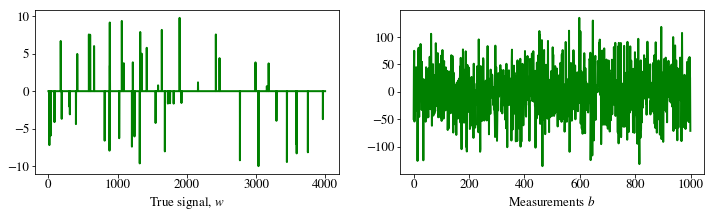

In [5]:
b, w = ls_data[0][1:]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3))
ax[0].plot(w, 'g')
ax[0].set_xlabel('True signal, $w$')
ax[1].plot(b, 'g')
ax[1].set_xlabel('Measurements $b$')
fig

Now we run the block-coordinate primal-dual method for our two problems. In the paper we run it for 1000 iterations, but you can take much less.

In [8]:
N = 1000
d_batch = 50
n_batch = n // d_batch
x0 = np.zeros(n)
results = np.zeros((4,N))
for i, data in enumerate(ls_data):
    A,b,w = data
    
    data_block = [A, b, w, x0, d_batch, n_batch]
    ans = run_coo(data_block,  N, j=j_step)
    ls1 = np.array(ans[-2]) # signal error
    ls2 = np.array(ans[-1]) # feas gap
    results[2*i] = ls1 
    results[2*i+1] = ls2

--------- block-PDA for Basis Pursuit -----------------------
CPU and elapsed time: 82.01154412100001 25.543374061584473
Optimality gap: 0.00022576548832842214
Feasibility gap: 0.023432920735
Number of iterations: -1
--------- block-PDA for Basis Pursuit -----------------------
CPU and elapsed time: 82.75673836100002 26.057985305786133
Optimality gap: 0.00020624971085547728
Feasibility gap: 0.0393692320575
Number of iterations: -1


"Number of iterations: $-1$" says that the method did not reach the desired accuracy, so it was running for $N$ iterations. This is not surprising, since our problem might be even inconsistent. We want to see the behavior of iterates: how the signal error and the feasibility gap were changing.

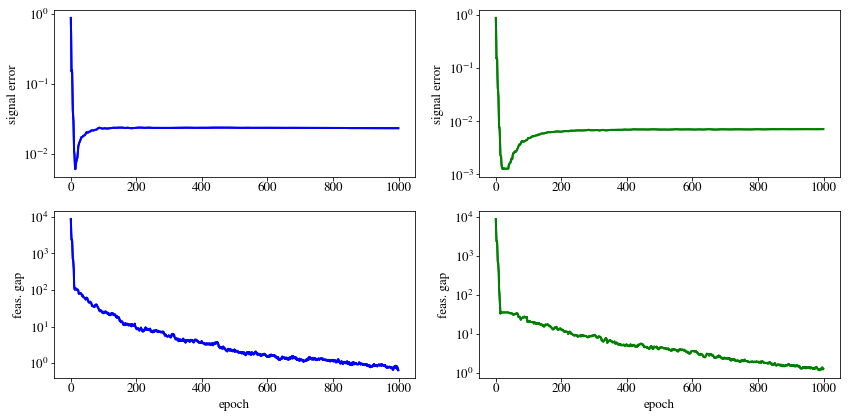

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
for i in range(2):
    ax[0,0].plot(results[0], 'b')
    ax[1,0].plot(results[1], 'b')
    
    
    ax[0,1].plot(results[2], 'g')
    ax[1,1].plot(results[3], 'g')
    
for a in ax.flatten():
    a.set_yscale('log')
    a.minorticks_off()
    
for j in [0,1]:
    ax[1, j].set_xlabel('epoch')
    ax[1, j].set_ylabel('feas. gap')
    ax[0, j].set_ylabel('signal error')

fig.tight_layout()

fig.savefig('results/bp-denoising-plot1.pdf', dpi=100)
fig

### Scenario 2
A is the product of two random Gaussian matrices of shapes (m, m/2) and (m/2, n) and noise is either random from $\mathcal N(0,1)$ or rounding off each coordinate of $b$ to the nearest integer


In [10]:
m, n = 1000, 4000

ls_data = []

# Example 1
A, b, w = generate_data(m, n, 50, matrix='low_rank', noise='normal', var=1, gen=1)
ls_data.append([A,b,w])

# Example 2
A, b, w = generate_data(m, n, 50, matrix='low_rank', noise='round-off', var=0, gen=1)
ls_data.append([A,b,w])

j_step = 20

Now we again run the block-coordinate primal-dual method for our two problems from the second scenario.

In [11]:
N = 1000
d_batch = 50
n_batch = n // d_batch
x0 = np.zeros(n)
results = np.zeros((4,N))
for i, data in enumerate(ls_data):
    A,b,w = data
    
    data_block = [A, b, w, x0, d_batch, n_batch]
    ans = run_coo(data_block,  N, j=j_step)
    ls1 = np.array(ans[-2]) # signal error
    ls2 = np.array(ans[-1]) # feas gap
    results[2*i] = ls1 
    results[2*i+1] = ls2

--------- block-PDA for Basis Pursuit -----------------------
CPU and elapsed time: 52.551647806000005 14.624061346054077
Optimality gap: 0.00011953287256183387
Feasibility gap: 2.8714840666
Number of iterations: -1
--------- block-PDA for Basis Pursuit -----------------------
CPU and elapsed time: 78.22141250000004 25.409528017044067
Optimality gap: 1.406475824694553e-06
Feasibility gap: 0.667208270967
Number of iterations: -1


"Number of iterations: $-1$" says that the method did not reach the desired accuracy, so it was running for $N$ iterations. This is not surprising, since our problem might be even inconsistent. We want to see the behavior of iterates: how the signal error and the feasibility gap were changing.

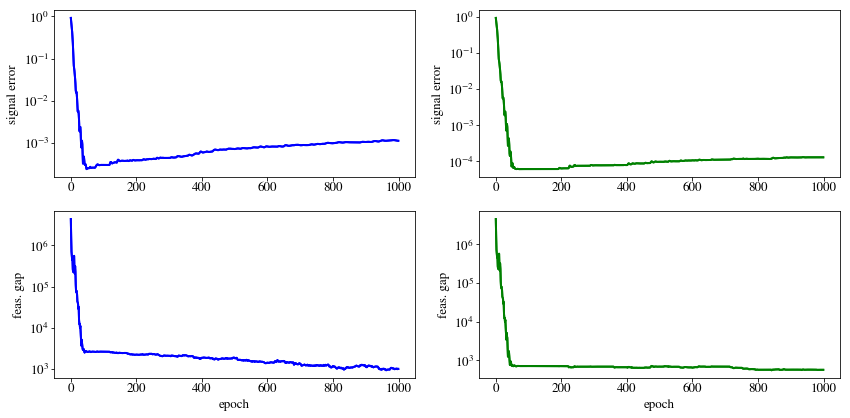

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
for i in range(2):
    ax[0,0].plot(results[0], 'b')
    ax[1,0].plot(results[1], 'b')
    
    
    ax[0,1].plot(results[2], 'g')
    ax[1,1].plot(results[3], 'g')
    
for a in ax.flatten():
    a.set_yscale('log')
    a.minorticks_off()
    
for j in [0,1]:
    ax[1, j].set_xlabel('epoch')
    ax[1, j].set_ylabel('feas. gap')
    ax[0, j].set_ylabel('signal error')

fig.tight_layout()

fig.savefig('results/bp-denoising-plot2.pdf', dpi=100)
fig

### Recovery of the realistic signal

Finally, we would like to illustrate the proposed approach on the
realistic non-sparse signal. We set $m=1000, n=4000$ and generate a random signal
$w\in \R^n$ that has a sparse representation in the dictionary of the
discrete cosine transform, that is $w = \Phi x^\dagger$ with the matrix
$\Phi\in \R^{n\times n}$ of the discrete cosine transform and
$x^\dagger \in \R^n$ is the sparse vector with only $50$ non-zero coordinates
drawn from $\mathcal N(0,1)$.  The measurements are modeled by a random
 Gaussian matrix $M\in \R^{m\times n}$. The observed data are
corrupted by noise: $b = Mw + \e$, where $\e\in \R^m$ is a
random vector, whose entries are drawn from $\mathcal N(0,10)$.

Obviously, we can rewrite the above equation as $b = Ax + \e$, where
$A = M\Phi\in \R^{m\times n}$.  We apply the proposed block-coordinate
primal-dual method to the problem
\begin{equation*}
    \min_x \|x\|_1 \quad \text{s.t.}\quad A x = b
\end{equation*}
with $\sigma = \frac{1}{2^{22}n_{\text{block}}}$ and the width $50$ of each block.

In [13]:
m,n = 1000, 4000

#define a sparse signal in the DCT dictionary
np.random.seed(0)
x_dct = np.random.normal(0, 1, n)
x_dct[50:] = 0
x_dct[:100] = np.random.permutation(x_dct[:100])


# define a matrix Phi of the DCT transform
Phi = dct(np.eye(n)).T

# define a matrix M that models our measurments
M = np.random.normal(0, 1., (m,n))

# The original signal w is defined by applying DCT to the given sparse signal
w = Phi.dot(x_dct)

#The noisy signal b which we observe is
b = M.dot(w) + np.random.normal(0,10,m)

# For us it is more convenient to define matrix A=M*Phi.
# @ is just a matrix-matrix multiplcation (quite a new notation)
A = M @ Phi


# define all the ingredients for Block-coo-PDA
x0 = np.zeros(n)

d_batch = 50
n_batch = n//d_batch
j_step = 22
data_block = [A, b, x_dct, x0, d_batch, n_batch]

Run the algorithm for 1000 epochs just to see how the iterates behave. It takes some time.

In [16]:
ans = run_coo(data_block,  1000, j=j_step)
x1000 = ans[0]

--------- block-PDA for Basis Pursuit -----------------------
CPU and elapsed time: 66.53415502600001 20.017263412475586
Optimality gap: 0.00018462566188925944
Feasibility gap: 0.829616814403
Number of iterations: -1


Plot the signal error and the feasibility gap for the iterates $x_k$:

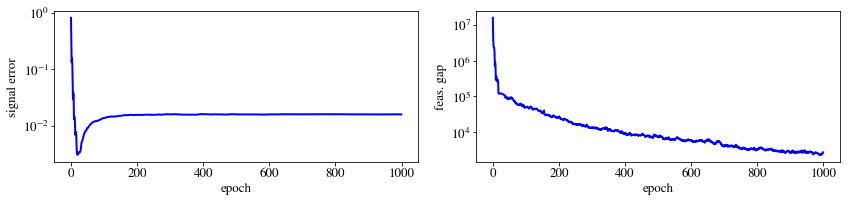

In [17]:
ls1 = np.array(ans[-2]) # signal error
ls2 = np.array(ans[-1]) # feas gap

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3), sharex=True)
ax[0].plot(ls1, 'b')
ax[1].plot(ls2, 'b')
ax[0].set_yscale('log')
ax[1].set_yscale('log')

for a in ax:
    a.set_xlabel('epoch')
    a.minorticks_off()

ax[0].set_ylabel('signal error')
ax[1].set_ylabel('feas. gap')

fig.tight_layout()
fig.savefig('results/bp-denoising-plot3.pdf', dpi=100)

fig

Now let us run the method only for 30 epochs

In [19]:
ans = run_coo(data_block,  N=30, j=j_step)

--------- block-PDA for Basis Pursuit -----------------------
CPU and elapsed time: 2.5569381419999786 0.8319098949432373
Optimality gap: 0.012108724336061139
Feasibility gap: 33.5656084374
Number of iterations: -1


We obtain a signal $x_{30}$. Recall, it belongs to the DCT domain. The reconstructed signal $w_{30}$ is

In [20]:
x30 = ans[0]
w30 = Phi.dot(x30)

We compare the reconstructed signal $w_{30}$ with the original signal $w$.

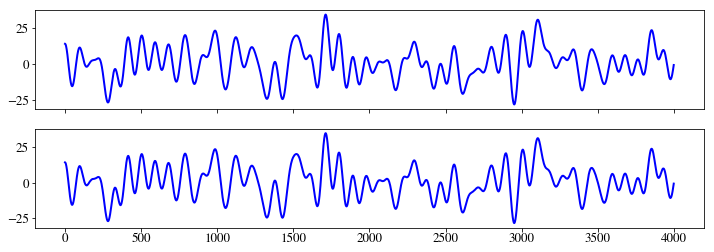

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4), sharex=True)
ax[0].plot(w, 'b',clip_on=False)
ax[1].plot(w30, 'b')

#ax[0].axhline()
#ax[0].spines['top'].set_visible(False)
#ax[0].spines['right'].set_visible(False)
#ax[0].spines['left'].set_visible(False)
#ax[0].yaxis.set_tick_params(right='off', direction='out', width=1)
#ax[0].yaxis.set_ticklabels([])
#ax[0].get_yaxis().set_visible(False)

fig.savefig('results/bp-denoising-plot4.pdf', dpi=100)

fig

The error $\frac{1}{n}\|w-w_{30}\|$ is

In [22]:
print("Error after 30 epochs is", LA.norm(w-w30)/LA.norm(w))

Error after 30 epochs is 0.0036201424010014463


It might be also interesting to compare the error if we reconstruct the signal after $N=1000$ epochs. In this case we have

In [23]:
w1000 = Phi.dot(x1000)
print("Error after 1000 epochs is", LA.norm(w-w1000)/LA.norm(w))

Error after 1000 epochs is 0.01575877749357806


This is also quite good.